In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import geodatasets
import os


In [3]:
# Load dataset
file_path = "../data/public_emdat_custom_request_2018-2024.xlsx"
df = pd.read_excel(file_path)

os.makedirs('../images/06_scatter', exist_ok=True)

print(f"Data Shape: {df.shape}")
df.head(3)


Data Shape: (4014, 47)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,GADM Admin Units,Entry Date,Last Update
0,2018-0040-BRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),DFO:4576,NaN,BRA,...,NaN,NaN,NaN,10000.0,12492.0,80.049596,"[{""adm2_code"":9961,""adm2_name"":""Rio De Janeiro""}]","[{""gid_2"":""BRA.19.68_2"",""migration_date"":""2025...",2018-02-20,2025-12-20
1,2022-0770-RWA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,RWA,...,NaN,NaN,NaN,NaN,NaN,93.294607,"[{""adm1_code"":21970,""adm1_name"":""Kigali City/U...","[{""gid_1"":""RWA.5_1"",""migration_date"":""2025-12-...",2022-11-25,2025-12-20
2,2024-9796-USA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,USA,...,NaN,NaN,NaN,5400000.0,5400000.0,100.000000,NaN,"[{""gid_1"":""USA.13_1"",""name_1"":""Idaho""},{""gid_1...",2024-10-29,2025-12-20


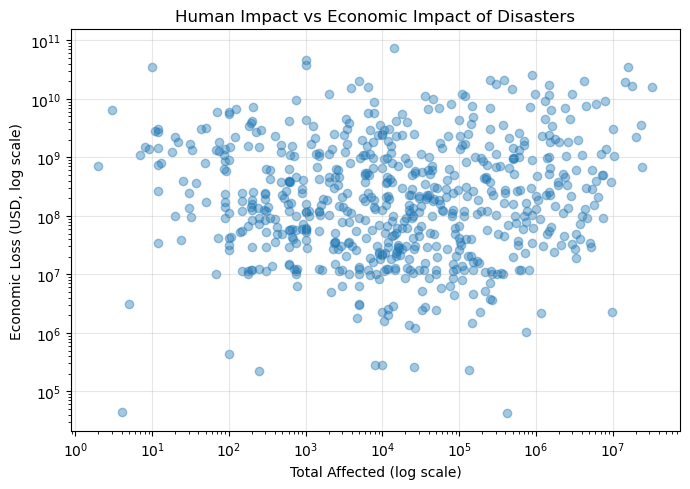

In [4]:
# =========================
# Human Impact vs Economic Impact
# =========================

scatter_df = df[
    ["Total Affected", "Total Damage, Adjusted ('000 US$)"]
].dropna()

scatter_df["econ_loss_usd"] = scatter_df["Total Damage, Adjusted ('000 US$)"] * 1000

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_df["Total Affected"],
    scatter_df["econ_loss_usd"],
    alpha=0.4
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total Affected (log scale)")
plt.ylabel("Economic Loss (USD, log scale)")
plt.title("Human Impact vs Economic Impact of Disasters")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/06_scatter/scatter_loss_vs_casualties.png', dpi=300, bbox_inches='tight')
plt.show()


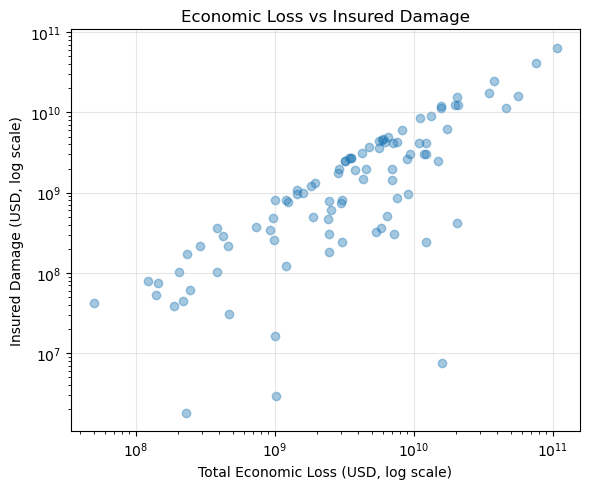

In [5]:
plt.figure(figsize=(6, 5))

s = df[
    ["Total Damage, Adjusted ('000 US$)", "Insured Damage, Adjusted ('000 US$)"]
].dropna()
s = s[(s.iloc[:,0] > 0) & (s.iloc[:,1] > 0)]

plt.scatter(
    s["Total Damage, Adjusted ('000 US$)"] * 1000,
    s["Insured Damage, Adjusted ('000 US$)"] * 1000,
    alpha=0.4
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total Economic Loss (USD, log scale)")
plt.ylabel("Insured Damage (USD, log scale)")
plt.title("Economic Loss vs Insured Damage")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


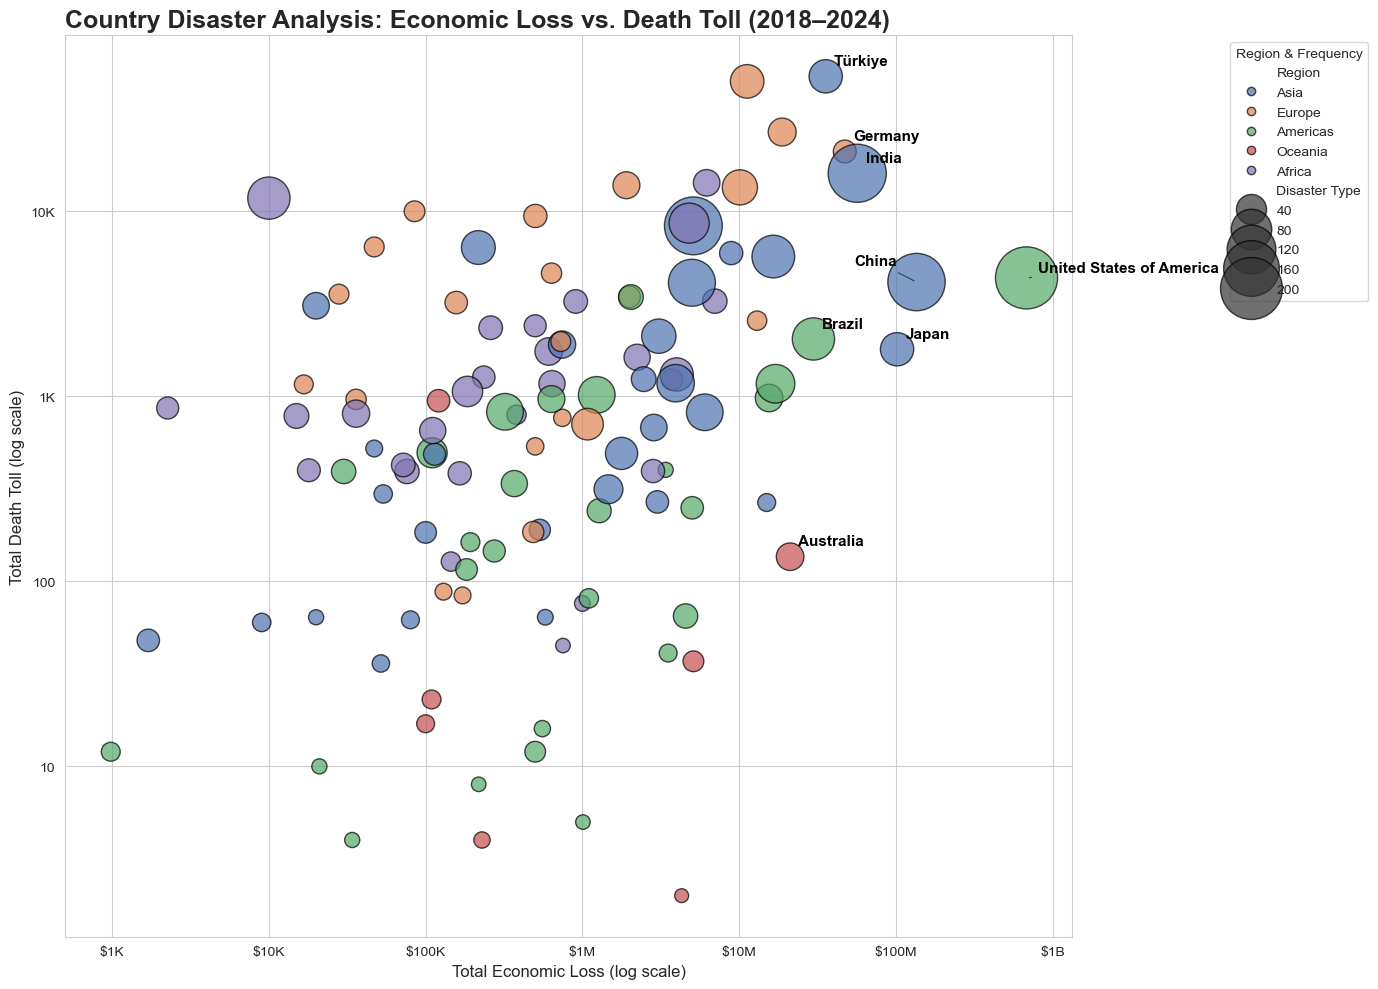

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# -----------------------------
# 1) Fix column names / missing values
# -----------------------------
# If the dataset still uses the old column name, rename it
if "Total Damage ('000 US$)" in df.columns:
    df.rename(columns={"Total Damage ('000 US$)": "Total_Damage_USD"}, inplace=True)

# Avoid errors: fill missing deaths with 0
if "Total Deaths" in df.columns:
    df["Total Deaths"] = df["Total Deaths"].fillna(0)

# -----------------------------
# 2) Aggregate by country (so we don't plot 50k points)
# -----------------------------
df_country = df.groupby(["Country", "ISO", "Region"]).agg({
    "Total_Damage_USD": "sum",   # Total economic loss
    "Total Deaths": "sum",       # Total deaths
    "Disaster Type": "count"     # Number of events (frequency proxy)
}).reset_index()

# Keep only valid countries for log-log plot
df_country = df_country[(df_country["Total_Damage_USD"] > 0) & (df_country["Total Deaths"] > 0)]

# -----------------------------
# 3) Bubble chart
# -----------------------------
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

regions = df_country["Region"].unique()
palette = sns.color_palette("deep", len(regions))

ax = sns.scatterplot(
    data=df_country,
    x="Total_Damage_USD",
    y="Total Deaths",
    hue="Region",
    size="Disaster Type",
    sizes=(100, 2000),
    palette=palette,
    alpha=0.7,
    edgecolor="black",
    linewidth=1
)

# Log scales
ax.set_xscale("log")
ax.set_yscale("log")

# -----------------------------
# 4) Axis formatting (human readable)
# -----------------------------
def currency_format(x, pos=None):
    x = float(x)
    if x >= 1e9: return f"${x*1e-9:.0f}B"
    if x >= 1e6: return f"${x*1e-6:.0f}M"
    if x >= 1e3: return f"${x*1e-3:.0f}K"
    return f"${x:.0f}"

def number_format(x, pos=None):
    x = float(x)
    if x >= 1e6: return f"{x*1e-6:.0f}M"
    if x >= 1e3: return f"{x*1e-3:.0f}K"
    return f"{x:.0f}"

ax.xaxis.set_major_formatter(ticker.FuncFormatter(currency_format))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(number_format))

# -----------------------------
# 5) Labels (fix USA/China overlap with offsets)
# -----------------------------
# Countries to label (top 8 by damage)
top_countries = df_country.nlargest(8, "Total_Damage_USD").copy()

# Ensure USA & China are labeled even if not in top 8
always_label = {"United States of America", "China"}
extra = df_country[df_country["Country"].isin(always_label)]
top_countries = pd.concat([top_countries, extra], ignore_index=True).drop_duplicates(subset=["Country"])

# Custom offsets for overlapping labels (in points)
label_offsets = {
    "United States of America": (8, 2),  # move right/up
    "China": (-14, 10),                   # move left/up
}

for _, row in top_countries.iterrows():
    country = row["Country"]
    dx, dy = label_offsets.get(country, (6, 6))  # default small offset

    ax.annotate(
        country,
        xy=(row["Total_Damage_USD"], row["Total Deaths"]),
        xytext=(dx, dy),
        textcoords="offset points",
        fontsize=11,
        fontweight="bold",
        color="black",
        ha="left" if dx >= 0 else "right",
        va="bottom",
        arrowprops=dict(arrowstyle="-", lw=0.8, color="black", alpha=0.6)
        if country in label_offsets else None
    )

# -----------------------------
# 6) Titles / labels / legend (English)
# -----------------------------
ax.set_title(
    "Country Disaster Analysis: Economic Loss vs. Death Toll (2018–2024)",
    fontsize=18,
    fontweight="bold",
    loc="left"
)
ax.set_xlabel("Total Economic Loss (log scale)", fontsize=12)
ax.set_ylabel("Total Death Toll (log scale)", fontsize=12)

# Legend
# 1) Legend'i daha dışarı al (sağa daha fazla boşluk bırak)
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left", title="Region & Frequency")

# 2) Sağda kalan etiketleri sola çek (USA özellikle)
label_offsets = {
    "United States of America": (-20, 0),  # sola çek
    "China": (-14, 10),
}


plt.tight_layout()
plt.savefig('../images/06_scatter/economic_loss_vs_deaths.png', dpi=300, bbox_inches='tight')
plt.show()
